In [16]:
import pandas as pd

# Load the merged outcome file
df = pd.read_csv("outcome_merged.csv")

# Create the column name for each run's difference
df['dif_label'] = 'dif_' + df['run_id']

# Select relevant columns
df = df[['comboID', 'dif_label', 'Difference (%)']]

# Aggregate duplicates by taking the mean Difference (%) for each comboID and run
df_agg = df.groupby(['comboID', 'dif_label'])['Difference (%)'].mean().reset_index()

# Pivot the table
pivot_df = df_agg.pivot(index='comboID', columns='dif_label', values='Difference (%)')



In [17]:
pivot_df

dif_label,dif_Felix1,dif_Felix2,dif_Felix3,dif_Felix4
comboID,,,,
0,18.36,25.25,31.7,1.2
1,25.62,5.45,12.8,7.2
2,4.60,10.70,36.8,26.6
3,15.86,20.35,20.9,16.3
4,16.74,4.25,1.1,17.5
...,...,...,...,...
675,23.40,17.80,21.4,20.7
676,2.70,21.80,20.2,13.0
677,19.90,2.30,31.4,19.8


In [18]:


# Calculate statistics across the dif_* columns
pivot_df['mean'] = pivot_df.mean(axis=1, skipna=True)
pivot_df['median'] = pivot_df.median(axis=1, skipna=True)
pivot_df['range'] = pivot_df.max(axis=1, skipna=True) - pivot_df.min(axis=1, skipna=True)
pivot_df['std_dev'] = pivot_df.std(axis=1, skipna=True) 

# Reset index to make comboID a column again
pivot_df = pivot_df.reset_index()

# Save to new file
pivot_df.to_csv("comboID_summary.csv", index=False)

print("Summary saved as comboID_summary.csv")


Summary saved as comboID_summary.csv


In [19]:
pivot_df

dif_label,comboID,dif_Felix1,dif_Felix2,dif_Felix3,dif_Felix4,mean,median,range,std_dev
0,0,18.36,25.25,31.7,1.2,19.1275,19.1275,30.50,10.233886
1,1,25.62,5.45,12.8,7.2,12.7675,12.7675,20.17,7.032064
2,2,4.60,10.70,36.8,26.6,19.6750,19.6750,32.20,11.427250
3,3,15.86,20.35,20.9,16.3,18.3525,18.3525,5.04,5.366722
4,4,16.74,4.25,1.1,17.5,9.8975,9.8975,16.40,6.456911
...,...,...,...,...,...,...,...,...,...
675,675,23.40,17.80,21.4,20.7,20.8250,20.8250,5.60,5.983502
676,676,2.70,21.80,20.2,13.0,14.4250,14.4250,19.10,6.402876
677,677,19.90,2.30,31.4,19.8,18.3500,19.8000,29.10,9.388043
678,678,30.20,26.10,31.9,25.3,28.3750,28.3750,6.60,8.532314


In [20]:
# Load the summary file
summary_df = pd.read_csv("comboID_summary.csv")

# Describe the 'range' column
range_description = summary_df['range'].describe()

# Print summary statistics
print("Range Column Summary Statistics:")
print(range_description)

Range Column Summary Statistics:
count    680.000000
mean      12.311216
std        6.614773
min        0.400000
25%        7.100000
50%       11.200000
75%       16.425000
max       35.300000
Name: range, dtype: float64


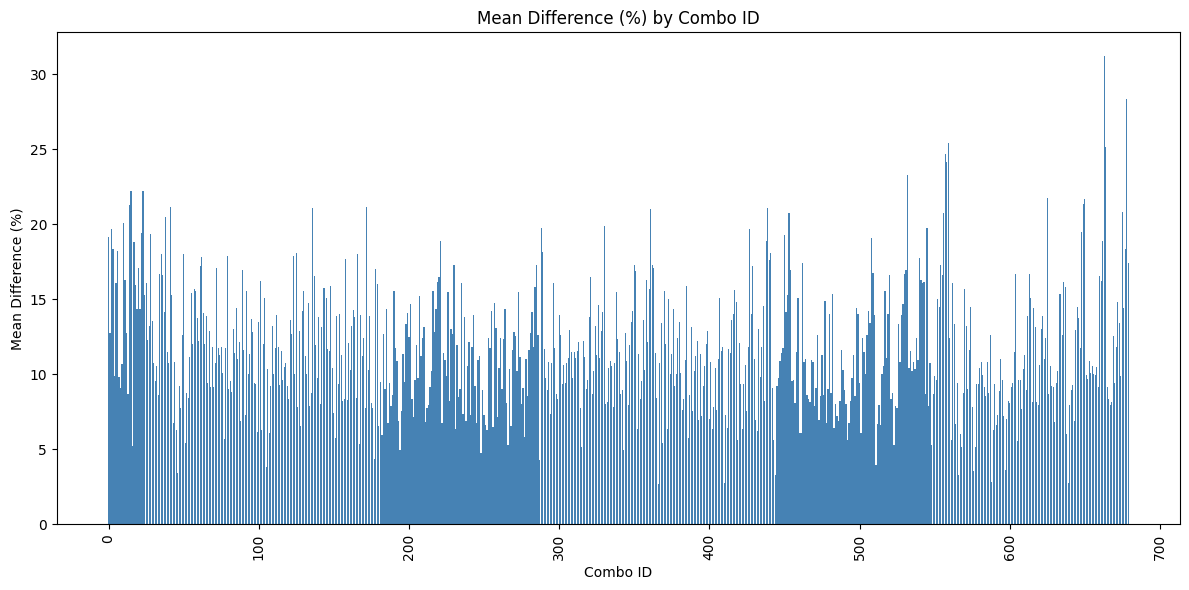

In [21]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.bar(summary_df['comboID'], summary_df['mean'], color='steelblue')
plt.xlabel('Combo ID')
plt.ylabel('Mean Difference (%)')
plt.title('Mean Difference (%) by Combo ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
summary_df.columns

Index(['comboID', 'dif_Felix1', 'dif_Felix2', 'dif_Felix3', 'dif_Felix4',
       'mean', 'median', 'range', 'std_dev'],
      dtype='object')

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import t

# Step 2: Calculate 95% confidence intervals for the mean
n = 4
df = n - 1
t_score = t.ppf(0.975, df)  # 95% CI two-tailed for df=3 ≈ 3.182
summary_df['ci_lower'] = summary_df['mean'] - t_score * (summary_df['std_dev'] / np.sqrt(n))
summary_df['ci_upper'] = summary_df['mean'] + t_score * (summary_df['std_dev'] / np.sqrt(n))

# Step 3: Determine the best observed mean performance (lowest % difference)
best_mean = summary_df['mean'].min()

# Step 4: Tagging combos based on confidence interval comparison
def tag_combo(row, best_mean):
    if row['ci_lower'] > best_mean + 10:
        return 'Eliminate'
    elif row['ci_upper'] < best_mean + 5:
        return 'Prioritize'
    else:
        return 'Explore'

summary_df['tag'] = summary_df.apply(lambda row: tag_combo(row, best_mean), axis=1)

# Step 5: Optional - sort for review
summary_df = summary_df.sort_values(by=['tag', 'mean'])

# Output result
summary_df[['comboID', 'mean', 'std_dev', 'ci_lower', 'ci_upper', 'tag']]


,comboID,mean,std_dev,ci_lower,ci_upper,tag
556,556,20.775000,4.896904,12.982932,28.567068,Eliminate
136,136,21.100000,5.196931,12.830523,29.369477,Eliminate
23,23,22.212500,5.439192,13.557531,30.867469,Eliminate
15,15,22.216667,5.774406,13.028297,31.405036,Eliminate
532,532,23.300000,5.996904,13.757588,32.842412,Eliminate
...,...,...,...,...,...,...
105,105,3.800000,0.989949,2.224769,5.375231,Prioritize
287,287,4.300000,1.516418,1.887040,6.712960,Prioritize
177,177,4.375000,1.056203,2.694345,6.055655,Prioritize
266,266,5.300000,1.309853,3.215732,7.384268,Prioritize


In [26]:
# Count how many of each tag
tag_counts = summary_df['tag'].value_counts()

# Display the result
print("Tag distribution:")
print(tag_counts)


Tag distribution:
tag
Explore       657
Prioritize     13
Eliminate      10
Name: count, dtype: int64


In [27]:
# Get list of comboIDs tagged as 'Eliminate'
eliminate_combos = summary_df[summary_df['tag'] == 'Eliminate']['comboID'].tolist()

# Output the list
print("Combos to eliminate:")
print(eliminate_combos)


Combos to eliminate:
[556, 136, 23, 15, 532, 558, 557, 664, 678, 663]


In [ ]:
action_df = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/0.5 - Summer 25/MGSC 670 - Revenue Management/Assignement/Retail_Mardown_Game/Retail_Mardown_Game/action_df.csv")



Index(['combo_number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15'],
      dtype='object')

In [30]:


# Create a new DataFrame excluding eliminated combos
action_df_eliminated = action_df[~action_df['combo_number'].isin(eliminate_combos)].copy()
action_df_eliminated.to_csv("C:/Users/felix/OneDrive/McGill Master Work/0.5 - Summer 25/MGSC 670 - Revenue Management/Assignement/Retail_Mardown_Game/Retail_Mardown_Game/action_df_eliminated.csv", index=False)

# Optional: Check how many rows were removed
print(f"Removed {len(action_df) - len(action_df_eliminated)} rows.")
print(f"Remaining rows: {len(action_df_eliminated)}")

# Preview the result
action_df_eliminated.head()


Removed 10 rows.
Remaining rows: 670


,combo_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A
1,1,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B
2,2,A,A,A,A,A,A,A,A,A,A,A,A,A,A,C
3,3,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D
4,4,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A
